### Simple Energy Balance on Venus

Here we'll create a simple energy balance model for Venus to derive a simple surface temperature:

$T_s = \left(\frac{(1-A)S}{4 \epsilon \sigma}\right)^{1/4}$

where we assume $\epsilon \approx 0.01$, $A \approx 0.75$, and $S = 2614$ W/m$^2$.

In [44]:
from astropy.constants import sigma_sb  # Stefan-Boltzmann constant
from astropy import units as u

# Constants
S = 2614 * (u.W / u.m**2)  # Solar constant at Venus
A = 0.9  # Albedo of Venus
epsilon = 0.004
# Effective emissivity
sigma = sigma_sb  # Stefan-Boltzmann constant

# Energy balance equation to solve for Ts (surface temperature)
Ts = (((1 - A) * S / (4 * epsilon * sigma)) ** 0.25).to(u.K)
print(f"Surface Temperature (Ts): {Ts:.2f}")


Surface Temperature (Ts): 732.64 K


Or, as a simple function:

In [45]:
# Function to calculate surface temperature Ts for a given solar constant S
def calculate_surface_temperature(S, A=0.9, epsilon=0.004):
    """
    Calculate the surface temperature (Ts) for a given solar constant (S).
    
    Parameters:
    - S: Solar constant (W/m^2) [Astropy quantity with units]
    - A: Planetary albedo (default: 0.75)
    - epsilon: Effective emissivity of the atmosphere (default: 0.01)
    
    Returns:
    - Ts: Surface temperature (K) [Astropy quantity with units]
    """
    Ts = (((1 - A) * S / (4 * epsilon * sigma_sb)) ** 0.25).to(u.K)
    return Ts

If we vary S over time:

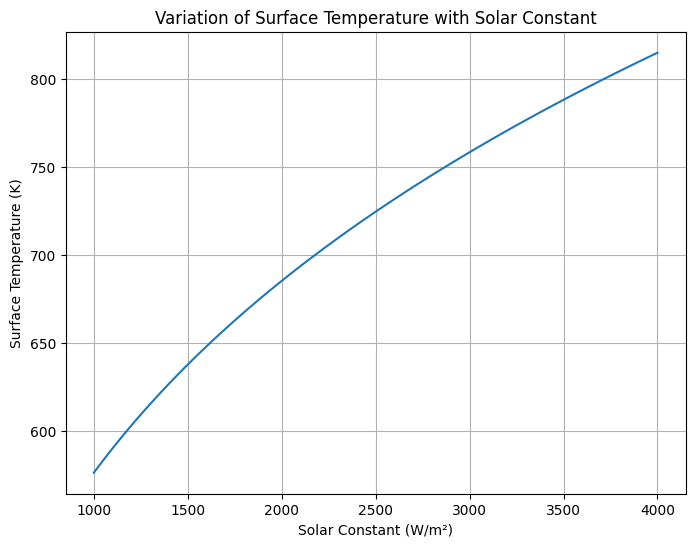

In [24]:
from astropy.constants import sigma_sb  

# Constants
A = 0.9  # Albedo of Venus
epsilon = 0.004  # Effective emissivity of the atmosphere

# Varying the solar constant (S) and calculating Ts
S_values = np.linspace(1000, 4000, 100) * (u.W / u.m**2)  # Solar constants in W/m^2
Ts_values = [calculate_surface_temperature(S) for S in S_values]

# Convert to dimensionless for plotting
S_values_plot = S_values.value
Ts_values_plot = [Ts.value for Ts in Ts_values]

# Plotting S vs. Ts
plt.figure(figsize=(8, 6))
plt.plot(S_values_plot, Ts_values_plot)
plt.xlabel("Solar Constant (W/m²)")
plt.ylabel("Surface Temperature (K)")
plt.title("Variation of Surface Temperature with Solar Constant")
plt.grid()
plt.show()


### Atmospheric Temperature Gradient Equation

The atmospheric temperature gradient can be expressed as:

$
\frac{dT}{dp} = \frac{1}{c_p(T)} \frac{RT}{p \mu}
$

#### Variables:
- **T**: Temperature (K) at a given pressure level in the atmosphere.
- **p**: Pressure (Pa), which decreases with altitude in the atmosphere.
- **$c_p(T)$**: Specific heat capacity at constant pressure, derived from the CO$_2$ Shomate Equation.
- **R**: Universal gas constant.
- **$\mu$**: Mean molecular weight of the atmosphere, determined by the atmospheric composition.

This equation describes how temperature changes with pressure in an atmosphere, accounting for the energy balance between thermal energy and atmospheric composition. The pressure decreases with altitude, causing a corresponding change in temperature as described by this gradient.


In [49]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import R as R_astropy
from astropy import units as u
import import_ipynb
from RKF12 import rkf12  

# Define constants with Astropy units
R = R_astropy.to(u.J / (u.mol * u.K))  # Universal gas constant (J/(mol K))
mu = 43.45 * u.g / u.mol  # Mean molecular weight, example for H2-dominated atmosphere
p0 = 1e5 * u.Pa  # Initial pressure in Pascals
T0 = Ts  # Initial temperature in Kelvin
p_end = 1e3 * u.Pa  # Final pressure in Pascals
h_init = 1000 * u.Pa  # Initial step size in Pascals
tol = 1e-5  # Tolerance for adaptive step size (dimensionless)

# Define temperature-dependent specific heat capacity (c_p) with units from Shomate Equation for CO2
def c_p(T):
    t = (T / 1000).value
    if T < 1200 * u.K:
        A = 24.99735
        B = 55.18696
        C = -33.69136
        D = 7.948387
        E = -0.136638

    elif T >= 1200 * u.K:
        A = 58.16639
        B = 2.720074
        C = -0.492289
        D = 0.038844
        E = -6.447293

    c_p = A + B*t + C*t**2 + D*t**3 + E/t**2
    return c_p * (u.J / (u.mol * u.K))  

# Define the differential equation dT/dp with units
def dT_dp(p, T):
    return ((R * T) / (p * mu * c_p(T))).to(u.K/u.Pa)

# Convert units to simplify computation in rkf12
def dT_dp_dimensionless(p, T):
    p = p * u.Pa
    T = T * u.K
    result = dT_dp(p, T)#.to(u.K / u.Pa)  # Convert to base units for integration
    return result.value

# Solve the ODE using RKF12
p_values, T_values = rkf12(dT_dp_dimensionless, p0.value, T0.value, p_end.value, h_init.value, tol)

# Convert results back to units
p_values = p_values * u.Pa
T_values = T_values * u.K

# Print the results
print(f"Temperature values: {T_values}")
print(f"Pressure values: {p_values}")


Temperature values: [732.64479067] K
Pressure values: [10000.] Pa


We can combine all of the results by using the solar constant to find surface temperature, then using that as an input to find T and P from the atmopsheric temperature gradient ODE. This gives the following plot.

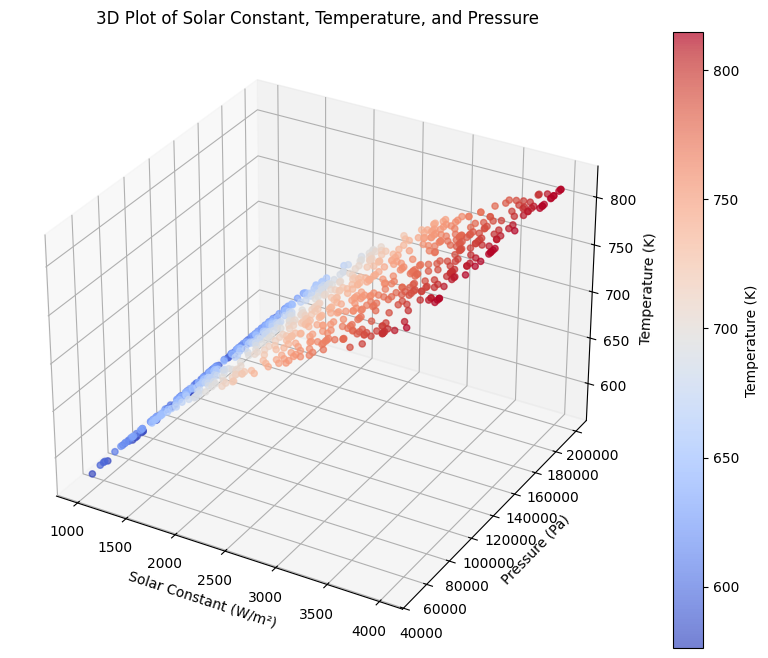

In [51]:
# Range of solar constants
S_values = np.linspace(1000, 4000, 30) * (u.W / u.m**2)  # Solar constants

# Random sampling of initial pressures for each S
num_samples = 25  # Number of random p0 samples per S
p0_min = 5e4 * u.Pa  # Minimum initial pressure
p0_max = 2e5 * u.Pa  # Maximum initial pressure

# Storage for results
S_results = []
P_results = []
T_results = []

# Loop over solar constants
for S in S_values:
    Ts = calculate_surface_temperature(S)
    for _ in range(num_samples):
        p0 = np.random.uniform(p0_min.value, p0_max.value) * u.Pa  # Random p0
        p_values, T_values = rkf12(dT_dp_dimensionless, p0.value, Ts.value, p_end.value, h_init.value, tol)
        S_results.extend([S.value] * len(p_values))
        P_results.extend(p_values)
        T_results.extend(T_values)

# Convert to numpy arrays
S_results = np.array(S_results)
P_results = np.array(P_results)
T_results = np.array(T_results)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for sampled data
scatter = ax.scatter(S_results, P_results, T_results, c=T_results, cmap='coolwarm', alpha=0.7)

# Labels and colorbar
ax.set_xlabel("Solar Constant (W/m²)")
ax.set_ylabel("Pressure (Pa)")
ax.set_zlabel("Temperature (K)")
ax.set_title("3D Plot of Solar Constant, Temperature, and Pressure")
fig.colorbar(scatter, label="Temperature (K)")

plt.show()